In [7]:
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 2.6 MB/s eta 0:00:00-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 MB 2.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 3.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [pytorch-forecasting]torch-forecasting]


# 1. Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from scipy.stats import chi2
# Make sure you have `VaRTransformer` and `FZ0Loss` classes defined above or imported


# Load your data
df = pd.read_csv("data/merged_data_with_realised_volatility.csv")  # or however you're loading it

# Calculate returns
df['return'] = df['close'].pct_change()
df['squared_return'] = df['return'] ** 2
df['target_return'] = df['return'].shift(-1)  # Target for FZ0 loss

# Drop NA values
df.dropna(inplace=True)

# Select features
features = [
    'return', 'squared_return',
    'gk_vol_1d', 'gk_vol_21d',
    'weighted_tavg', 'weighted_prcp',
    'Fed_Rate', 'GDP', 'CPI'
]

X = df[features].values
y = df['target_return'].values

# print(X.shape)
# print(y.shape)

# 2. Standardisation and Sequence Creation

In [26]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create input sequences for Transformer
def create_sequences(X, y, seq_len=21):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y)


# 3. Model Definition: Transformer for Regression

In [27]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


class VaRTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_linear = nn.Linear(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.layer_norm = nn.LayerNorm(model_dim)
        self.output_head = nn.Linear(model_dim, 2)  # Output: [VaR, ES]

    def forward(self, x):
        x = self.input_linear(x)           # [batch, seq_len, model_dim]
        x = self.positional_encoding(x)    # add positional info
        x = self.transformer(x)            # pass through transformer encoder
        x = self.layer_norm(x[:, -1])      # use last time step, normalize
        out = self.output_head(x)

        out = -torch.clamp(torch.abs(out), min=1e-2)  # instead of -abs
        return out


# 4. FZ0 Loss

In [28]:
class FZ0Loss(nn.Module):
    def __init__(self, alpha=0.05):
        super().__init__()
        self.alpha = alpha

    def forward(self, y_true, y_pred):
        var, es = y_pred[:, 0], y_pred[:, 1]
        eps = 1e-6
        es = torch.clamp(es, max=-eps)
        var = torch.clamp(var, max=-eps)
        indicator = (y_true <= var).float()
        term1 = - (1 / (self.alpha * es)) * indicator * (var - y_true)
        term2 = (var / es) + torch.log(-es + eps) - 1
        return torch.mean(term1 + term2)


# Train with early stopping

In [30]:
def train_with_early_stopping(X_seq, y_seq, input_dim, max_epochs=50, batch_size=32, patience=5):
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32)
    
    val_size = int(0.2 * len(X_tensor))
    train_size = len(X_tensor) - val_size
    train_dataset, val_dataset = random_split(TensorDataset(X_tensor, y_tensor), [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = VaRTransformer(input_dim=input_dim)
    loss_fn = FZ0Loss(alpha=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_batch, y_pred)
            if not torch.isfinite(loss):
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()

        scheduler.step()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                y_val_pred = model(X_val)
                val_loss = loss_fn(y_val, y_val_pred)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, X_tensor, y_tensor

In [31]:
def evaluate_and_plot(model, X_tensor, y_tensor, threshold_alpha=0.05):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).cpu().numpy()
    y_true = y_tensor.cpu().numpy()
    predicted_var = y_pred[:, 0]
    predicted_es = y_pred[:, 1]

    hits = (y_true <= predicted_var).astype(int)
    hit_rate = hits.mean()
    n = len(y_true)
    x = hits.sum()
    p_hat = x / n
    if p_hat == 0 or p_hat == 1:
        LR_pof = float('inf')
        p_value = 0.0
    else:
        LR_pof = -2 * (np.log((1 - threshold_alpha)**(n - x) * threshold_alpha**x) -
                       np.log((1 - p_hat)**(n - x) * p_hat**x))
        p_value = 1 - chi2.cdf(LR_pof, df=1)

    breach_returns = y_true[hits == 1]
    avg_actual_es = breach_returns.mean() if len(breach_returns) > 0 else np.nan
    avg_predicted_es = predicted_es[hits == 1].mean() if len(breach_returns) > 0 else np.nan

    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual Returns', alpha=0.7)
    plt.plot(predicted_var, label=f'Predicted VaR ({threshold_alpha*100:.0f}%)', color='red')
    plt.scatter(np.where(hits)[0], y_true[hits == 1], color='black', label='Breaches', zorder=5)
    plt.title("VaR Backtesting")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Hit rate: {hit_rate:.4f} (Expected: {threshold_alpha})")
    print(f"Kupiec Test LR_pof: {LR_pof:.4f}, p-value: {p_value:.4f}")
    print(f"Average Actual Return under VaR: {avg_actual_es:.4f}")
    print(f"Average Predicted ES: {avg_predicted_es:.4f}")

Epoch 1, Train Loss: -1.231811, Val Loss: -1.815487
Epoch 2, Train Loss: -1.890372, Val Loss: -2.009121
Epoch 3, Train Loss: -2.117283, Val Loss: -2.212943
Epoch 4, Train Loss: -2.249256, Val Loss: -2.550284
Epoch 5, Train Loss: -2.346629, Val Loss: -2.163016
Epoch 6, Train Loss: -2.530448, Val Loss: -2.700535
Epoch 7, Train Loss: -2.683989, Val Loss: -2.720632
Epoch 8, Train Loss: -2.640860, Val Loss: -2.946649
Epoch 9, Train Loss: -2.710710, Val Loss: -2.895212
Epoch 10, Train Loss: -2.755024, Val Loss: -2.984748
Epoch 11, Train Loss: -2.838838, Val Loss: -3.037229
Epoch 12, Train Loss: -2.866203, Val Loss: -3.110200
Epoch 13, Train Loss: -2.878365, Val Loss: -2.981018
Epoch 14, Train Loss: -2.877645, Val Loss: -2.918242
Epoch 15, Train Loss: -2.934962, Val Loss: -3.072319
Epoch 16, Train Loss: -2.963770, Val Loss: -3.072726
Epoch 17, Train Loss: -2.893639, Val Loss: -2.966087
Early stopping triggered.


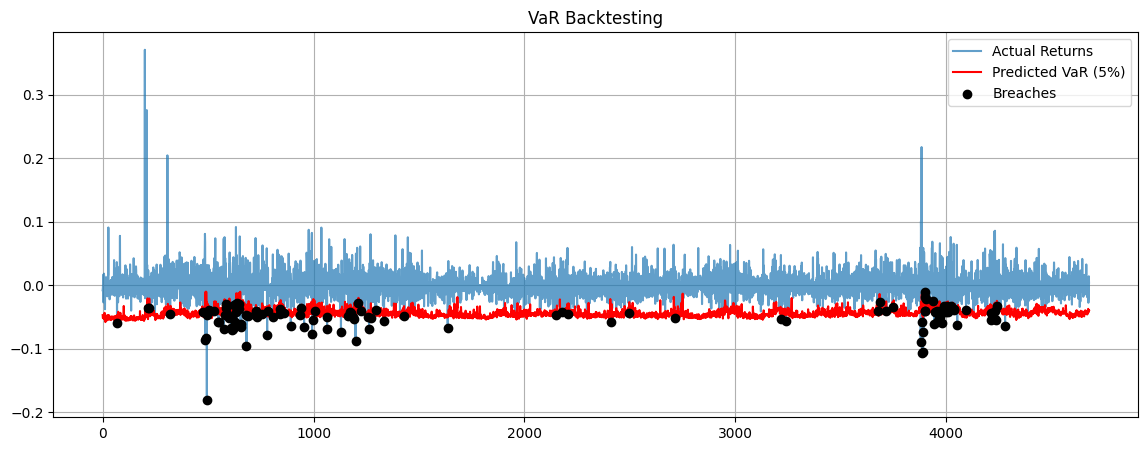

Hit rate: 0.0261 (Expected: 0.05)
Kupiec Test LR_pof: 67.7813, p-value: 0.0000
Average Actual Return under VaR: -0.0507
Average Predicted ES: -0.0743


In [32]:
# Example call (adjust input_dim if needed)
model, X_tensor, y_tensor = train_with_early_stopping(X_seq, y_seq, input_dim=X_seq.shape[2], max_epochs=50)
evaluate_and_plot(model, X_tensor, y_tensor)
